# Import Packages

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

# Function to Clean and Transpose the Data

In [2]:
def balancesheet_preprocess(file, exchange_rate = 0.95059):
    df = pd.read_csv(file) #Importing file
    col = len(df.columns) #Count No of Columns
    if col == 1:
        df = pd.read_csv(file, sep = '\t') #Import the file again if all the data is in 1 column
    header = list(df.columns) #Get the header names in a list
    header_count = len(header) #Count the number of elements in list
    for c in range(1, header_count): #Loop through all the columns  for formatting the numbers
        try:
            df[header[c]] = df[header[c]].astype(float)/1000000
        except:
            df[header[c]] = df[header[c]].str.replace(',', '').astype(float)/1000000
    for i in range(1, header_count): #Converting all the numbers to exchange rate
        df[header[i]] = df[header[i]] / exchange_rate
    df[header[0]] = df[header[0]].str.lstrip() #Remove Indentation
    df_t = df.set_index(header[0]).T #Transpose the data
    df_t = df_t.fillna(0) #Fill NA
    df_t.reset_index(inplace = True) #Temporarily create another index 
    df_t.rename(columns = {'index':'As on'}, inplace = True) #Rename the date column
    df_t.set_index('As on', inplace=True) #Make the Date column as index
    balancesheet_preprocess.df_bs = df_t #Name the variable appropriately

In [3]:
def incomestatement_preprocess(file, exchange_rate = 0.95059):
    df = pd.read_csv(file) #Importing file
    col = len(df.columns) #Count No of Columns
    if col == 1:
        df = pd.read_csv(file, sep = '\t') #Import the file again if all the data is in 1 column
    header = list(df.columns) #Get the header names in a list
    header_count = len(header) #Count the number of elements in list
    for c in range(1, header_count): #Loop through all the columns  for formatting the numbers
        try:
            df[header[c]] = df[header[c]].astype(float)/1000000
        except:
            df[header[c]] = df[header[c]].str.replace(',', '').astype(float)/1000000
    for i in range(1, header_count): #Converting all the numbers to exchange rate
        df[header[i]] = df[header[i]] / exchange_rate
    df[header[0]] = df[header[0]].str.lstrip() #Remove Indentation
    df_t = df.set_index(header[0]).T #Transpose the data
    df_t = df_t.fillna(0) #Fill NA
    df_t.reset_index(inplace = True) #Temporarily create another index 
    df_t.rename(columns = {'index':'As on'}, inplace = True) #Rename the date column
    df_t.set_index('As on', inplace=True) #Make the Date column as index
    incomestatement_preprocess.df_is = df_t #Name the variable appropriately

In [4]:
def cashflow_preprocess(file, exchange_rate = 0.95059):
    df = pd.read_csv(file) #Importing file
    col = len(df.columns) #Count No of Columns
    if col == 1:
        df = pd.read_csv(file, sep = '\t') #Import the file again if all the data is in 1 column
    header = list(df.columns) #Get the header names in a list
    header_count = len(header) #Count the number of elements in list
    for c in range(1, header_count): #Loop through all the columns  for formatting the numbers
        try:
            df[header[c]] = df[header[c]].astype(float)/1000000
        except:
            df[header[c]] = df[header[c]].str.replace(',', '').astype(float)/1000000
    for i in range(1, header_count): #Converting all the numbers to exchange rate
        df[header[i]] = df[header[i]] / exchange_rate
    df[header[0]] = df[header[0]].str.lstrip() #Remove Indentation
    df_t = df.set_index(header[0]).T #Transpose the data
    df_t = df_t.fillna(0) #Fill NA
    df_t.reset_index(inplace = True) #Temporarily create another index 
    df_t.rename(columns = {'index':'As on'}, inplace = True) #Rename the date column
    df_t.set_index('As on', inplace=True) #Make the Date column as index
    cashflow_preprocess.df_cf = df_t #Name the variable appropriately

# Calculation Function

In [5]:
def calculation(shareprice, shareoutstanding, wacc = 0.07):
    df_cal = pd.DataFrame() #Create an empty dataframe
    
    ppe = balancesheet_preprocess.df_bs['Net Property, Plant and Equipment'] #Store ppe values
    ca = balancesheet_preprocess.df_bs['Total Current Assets'] #Store current assets values
    cl = balancesheet_preprocess.df_bs['Total Current Liabilities'] #Store current liabilities value
    df_cal['Invested capital'] = ppe + ca - cl #Calculate invested capital PART 1
    
    net_income = incomestatement_preprocess.df_is['Net Income from Continuing Operations'] #Store net income
    interest = incomestatement_preprocess.df_is['Interest Expense Net of Capitalized Interest'] #Store capitalized interest
    non_operate_one_time = incomestatement_preprocess.df_is['Non-Operating Income/Expenses, Total'] #Store Other income
    nopat = net_income + interest - non_operate_one_time #Calculate nopat
    nopat_df = nopat.to_frame() #Convert nopat to df
    nopat_df = nopat_df.rename(columns = {0: 'nopat'}) #Rename column
    nopat_df = nopat_df.reset_index() #Reset Index
    nopat_df['As on'] = pd.to_datetime(nopat_df['As on'], errors='coerce') #Format Date column
    nopat_df['month_year'] = pd.to_datetime(nopat_df['As on']).dt.to_period('M') #Extract month and year
    df_cal = df_cal.reset_index() #Reset index to get access to datefield
    df_cal['month_year'] = pd.to_datetime(df_cal['As on']).dt.to_period('M') #Extract month and year and store in df
    df_cal = pd.merge(df_cal, nopat_df, how = 'inner', on = 'month_year') #merge df
    epv = nopat / wacc #Calculate epv
    epv_df = epv.to_frame() #Convert EPV to df
    epv_df = epv_df.rename(columns = {0:'EPV'}) # renaming column
    epv_df = epv_df.reset_index() #Converting Date from index to column
    epv_df['As on'] = pd.to_datetime(epv_df['As on'], errors='coerce') #Format Date column
    epv_df['month_year'] = pd.to_datetime(epv_df['As on']).dt.to_period('M') #Extract month and year and store in df
    df_cal = pd.merge(df_cal, epv_df, how='inner', on = 'month_year')
    #Merge file with monthlyshare to get only relevant data
    df_cal['PV No-growth value of competitive advantage'] = epv_df['EPV'] - df_cal['Invested capital']
    #Calculate PV PART 2
    
    df_cal['ROIC'] = nopat_df['nopat'] / df_cal['Invested capital'] #Calculate ROIC PART 3
    
    df_cal['WACC'] = wacc #WACC PART 4
    
    share_price = pd.read_csv(shareprice) #Importing file
    col = len(share_price.columns) #Count No of Columns
    if col == 1:
        share_price = pd.read_csv(shareprice, sep = '\t') #Import the file again if all the data is in 1 column
    sp_header = list(share_price.columns) #Get the list of headers
    share_price[sp_header[0]] = pd.to_datetime(share_price[sp_header[0]]) #Convert to datetime
    eom = share_price.resample(on=sp_header[0], rule="M").max().reset_index(drop=True) #Get the last date of each month
    df_monthlyshare = pd.merge(eom, share_price, how='left', on = sp_header[0]) #Merge last date df with shareprice df
    df_monthlyshare['month_year'] = pd.to_datetime(df_monthlyshare[sp_header[0]]).dt.to_period('M') 
    #Extract month and year   
    df_cal = pd.merge(df_cal, df_monthlyshare, how='inner', on = 'month_year') 
    #Merge temp file with monthlyshare to get only relevant data
    share_outstanding = pd.read_csv(shareoutstanding) #Importing file
    col = len(share_outstanding.columns) #Count No of Columns
    if col == 1:
        share_outstanding = pd.read_csv(shareoutstanding, sep = '\t') 
        #Import the file again if all the data is in 1 column
    so_header = list(share_outstanding.columns) #Get the list of headers
    share_outstanding['month_year'] = pd.to_datetime(share_outstanding[so_header[0]]).dt.to_period('M') 
    #Extract month and year
    df_cal = pd.merge(df_cal, share_outstanding, how='inner', on = 'month_year') 
    #merge shareoutstanding and temp dataframe to get only relevant data
    try: #Convert outstanding share column to float
        df_cal['Shares Outstanding (Millions)'] = df_cal['Shares Outstanding (Millions)'].astype(float)
    except:
        df_cal['Shares Outstanding (Millions)'] = df_cal['Shares Outstanding (Millions)'].str.replace(',', ''). \
        astype(float)
    df_cal = df_cal.rename(columns = {'Close_y': 'SharePrice'})
    df_cal['MarketCap'] = df_cal['Shares Outstanding (Millions)'] * df_cal['SharePrice'] #Calculate Market Value
    calculation.marketcap = pd.DataFrame() #Need it to calculate bookvalue ratio
    calculation.marketcap = df_cal[[so_header[0], 'MarketCap']]
    cash = balancesheet_preprocess.df_bs['Cash and Cash Equivalents'] #Store cash value
    total_debt = balancesheet_preprocess.df_bs['Long Term Debt'] #Stor long term debt value
    cash_debt_net = total_debt - cash #Calculate debt - cash
    cash_debt_net_df = cash_debt_net.to_frame() #Convert EPV to df
    cash_debt_net_df = cash_debt_net_df.rename(columns = {0:'Debt_less_cash'}) # renaming column
    cash_debt_net_df = cash_debt_net_df.reset_index() #Converting Date from index to column
    cash_debt_net_df['As on'] = pd.to_datetime(cash_debt_net_df['As on'], errors='coerce')
    cash_debt_net_df['month_year'] = pd.to_datetime(cash_debt_net_df['As on']).dt.to_period('M') \
    #Extract month and year and store in df
    df_cal = pd.merge(df_cal, cash_debt_net_df, how='inner', on = 'month_year') 
    df_cal['EnterpriseValue'] = df_cal['MarketCap'] + df_cal['Debt_less_cash'] #Calculate Enterprise value
    df_cal['Market Implied value of growth'] = df_cal['EnterpriseValue'] - df_cal['EPV'] #Calculate Market growth POINT 5
    
    df_cal['Invested capital%'] = df_cal['Invested capital'] / df_cal['EnterpriseValue'] #Calculate Investedcapital% PART 6
    
    df_cal['PV No-growth value of competitive advantage%'] =  \
    df_cal['PV No-growth value of competitive advantage'] / df_cal['EnterpriseValue'] 
    #Calculate PV% PART 7
    
    df_cal['Market Implied value of growth%'] = df_cal['Market Implied value of growth'] / df_cal['EnterpriseValue']
    #Calculate Market growth% PART 8
    
    
    calculation.output = df_cal[[so_header[0], 'ROIC', 'WACC', 'Invested capital', 'Invested capital%', \
                                 'PV No-growth value of competitive advantage',\
                                 'PV No-growth value of competitive advantage%','Market Implied value of growth',\
                                'Market Implied value of growth%', 'SharePrice']]#Select column of interest
    format_mapping={so_header[0]: '{}','ROIC': '{:.4f}', 'WACC': '{:.2f}', 'Invested capital': '{:,.0f}', \
                    'Invested capital%' : '{:.2f}', \
                   'PV No-growth value of competitive advantage' : '{:,.0f}', \
                    'PV No-growth value of competitive advantage%' : '{:.2f}', \
                    'Market Implied value of growth' : '{:,.0f}', 'Market Implied value of growth%' : '{:.2f}', \
                   'SharePrice': '{:.2f}'} 
    #Format numbers
    for key, value in format_mapping.items():
        calculation.output[key] = calculation.output[key].apply(value.format)
    
                   

# CAGR Function

In [6]:
def cagr():
    latest_ic = calculation.output['Invested capital%'].iloc[-1] #grab latest Invested capital%
    latest_ic = float(latest_ic) #convert string to float
    latest_mv = calculation.output['PV No-growth value of competitive advantage%'].iloc[-1] #grab latest no growth value%
    latest_mv = float(latest_mv) #convert string to float
    epv = latest_ic + latest_mv #calculate epv%
    epv_five_years_w = (0.65/epv)**(1/5)
    epv_five_years = epv_five_years_w - 1 #calculate epv 5 years
    epv_seven_years_w = (0.63/epv)**(1/7)
    epv_seven_years = epv_seven_years_w - 1 #calculate epv 7 years
    epv_ten_years_w = (0.60/epv)**(1/10)
    epv_ten_years = epv_ten_years_w - 1 #calculate epv 10 years
    
    epv_times_five_years = (1 + epv_five_years)**5 #calculate times epv 5 years
    epv_times_seven_years = (1 + epv_seven_years)**7 #calculate times epv 7 years
    epv_times_ten_years = (1 + epv_ten_years)**10 #calculate times epv 10 years
    
    ig = calculation.output['Market Implied value of growth%'].iloc[-1] #grab market value growth%
    ig = float(ig) #convert string to float
    ig_five_years_w = abs(0.40/ig)**(1/5)
    ig_five_years = ig_five_years_w - 1 #calculate value 5 years
    ig_seven_years_w = abs(0.37/ig)**(1/7)
    ig_seven_years = ig_seven_years_w - 1 #calculate value 7 years
    ig_ten_years_w = abs(0.35/ig)**(1/10)
    ig_ten_years = ig_ten_years_w - 1 #calculate value 10 years
    
    ig_times_five_years = (1+ ig_five_years)**5 #calculate times value 5 years
    ig_times_seven_years = (1+ ig_seven_years)**7 #calculate times value 7 years
    ig_times_ten_years = (1+ ig_ten_years)**10 #calculate times value 10 years
    
    year_walk = ['5 years %', '7 years %', '10 years %'] #create a year list
    epv_list = [epv_five_years, epv_seven_years, epv_ten_years] #create epv list
    epv_times_list = [epv_times_five_years, epv_times_seven_years, epv_times_ten_years] #create times epv list
    ig_list = [ig_five_years, ig_seven_years, ig_ten_years] #create value list
    ig_times = [ig_times_five_years, ig_times_seven_years, ig_times_ten_years] #create times value list
    
    cagr_df = pd.DataFrame() #create empty dataframe
    #Create relevant columns and insert relevant lists
    cagr_df['Years'] = year_walk 
    cagr_df['Market implied EPV Growth CAGR'] = epv_list
    cagr_df['No of times Market implied EPV Growth CAGR'] = epv_times_list
    cagr_df['Market implied Value of Growth CAGR'] = ig_list
    cagr_df['No of times Market implied Value of Growth CAGR'] = ig_times
    
    cagr.cagr_df = cagr_df #store df in callable format
    

# Book Value

In [7]:
def bookvalue():
    mc_header = list(calculation.marketcap.columns) #Get the list of headers
    total_assets = balancesheet_preprocess.df_bs['Total Assets'] #grab total assets
    total_liabilities = balancesheet_preprocess.df_bs['Total Liabilities'] #grab total liabilities
    book_value = total_assets - total_liabilities #calculate book value
    book_value_df = book_value.to_frame() #push bookvalue to df
    book_value_df = book_value_df.rename(columns = {0:'BookValue'}) #rename column
    book_value_df = book_value_df.reset_index() # reset index
    book_value_df = book_value_df.rename(columns = {'As on': mc_header[0]}) #make the name of merge column same
    book_value_df[mc_header[0]] = pd.to_datetime(book_value_df[mc_header[0]], errors='coerce') #convert to bv df datetime
    calculation.marketcap[mc_header[0]] = pd.to_datetime(calculation.marketcap[mc_header[0]], errors='coerce') #convert to 
    #mc df datetime
    book_value_df[mc_header[0]] = book_value_df[mc_header[0]].dt.strftime('%m/%d/%Y') #format datetime
    calculation.marketcap[mc_header[0]] = calculation.marketcap[mc_header[0]].dt.strftime('%m/%d/%Y') #format datetime
    calculation.marketcap = pd.merge(calculation.marketcap, book_value_df, how='inner', on = mc_header[0]) #merge both df
    calculation.marketcap['Mkt Cap B/M ratio'] =  calculation.marketcap['BookValue'] / calculation.marketcap['MarketCap'] 
    #calculate B/M ratio
    

    format_mapping={mc_header[0]: '{}', 'MarketCap' : '{:,.0f}','BookValue': '{:,.0f}', 'Mkt Cap B/M ratio': '{:.4f}'} 
        #Format numbers
    for key, value in format_mapping.items():
        calculation.marketcap[key] = calculation.marketcap[key].apply(value.format)
        
    bookvalue.out = calculation.marketcap #save the df in callable name
    bookvalue.out = bookvalue.out[['Year','BookValue','MarketCap','Mkt Cap B/M ratio']]

# Charts

In [8]:
def chart():
    column_names = list(calculation.output) #get the column names in list
    column_count = len(column_names) #get the count of columns
    for i in range (1, column_count):#convert column to float
        try:
            calculation.output[column_names[i]] = calculation.output[column_names[i]].astype(float)
        except:
            calculation.output[column_names[i]] = calculation.output[column_names[i]].str.replace(',', '').astype(float)
     
    chart.x = calculation.output[column_names[0]] #get x value for all the charts
       
    chart.ic_value_y = calculation.output[column_names[3]] #get y value for invested capital amount 
        
    chart.pv_value_y = calculation.output[column_names[5]] #get y value for PV no growth amount
        
    chart.mv_value_y = calculation.output[column_names[7]] #get y value for market value amount
        
    chart.ic_percent_y = calculation.output[column_names[4]] #get y value for invested capital percent
        
    chart.pv_percent_y = calculation.output[column_names[6]] #get y value for PV no growth percent
        
    chart.mv_percent_y = calculation.output[column_names[8]] #get y value for market value percent
    
    chart.stack_value = calculation.output[[column_names[0], column_names[3], column_names[5], column_names[7]]]
    chart.stack_value.set_index(column_names[0], inplace=True) #create a df with relevant columns
    
    chart.stack_percent = calculation.output[[column_names[0], column_names[4], column_names[6], column_names[8], \
                                             column_names[9]]] #create a df with relevant columns
    chart.column_names = column_names #assigning calllable name to list of column headers

# Call all the Function

In [9]:
balancesheet_preprocess(r'C:\Users\91709\Downloads\Work\UpWork\Brian\Case 1\Python Coding\Data\balancesheet.csv')

incomestatement_preprocess(r'C:\Users\91709\Downloads\Work\UpWork\Brian\Case 1\Python Coding\Data\incomestatement.csv')

cashflow_preprocess(r'C:\Users\91709\Downloads\Work\UpWork\Brian\Case 1\Python Coding\Data\cashflow.csv')

calculation('C:/Users/91709/Downloads/Work/UpWork/Brian/Case 1/Python Coding/Data/stockprices.csv', \
            'C:/Users/91709/Downloads/Work/UpWork/Brian/Case 1/Python Coding/Data/sharesoutstanding.csv')

cagr()

bookvalue()

chart()


# Get the output

In [10]:
calculation.output

,Year,ROIC,WACC,Invested capital,Invested capital%,PV No-growth value of competitive advantage,PV No-growth value of competitive advantage%,Market Implied value of growth,Market Implied value of growth%,SharePrice
0,31/12/2011,0.2085,0.07,603668.0,0.40,1194042.0,0.80,-304260.0,-0.20,75.90
1,31/12/2012,0.1860,0.07,667809.0,0.37,1106382.0,0.61,37426.0,0.02,90.65
2,31/12/2013,0.1603,0.07,694835.0,0.44,896643.0,0.57,-24123.0,-0.02,78.60
3,31/12/2014,0.1327,0.07,740428.0,0.41,663107.0,0.37,402963.0,0.22,91.40
4,31/12/2015,0.1211,0.07,695675.0,0.41,508284.0,0.30,508908.0,0.30,87.50
5,31/12/2016,0.1223,0.07,802097.0,0.51,599770.0,0.38,186106.0,0.12,82.20
6,31/12/2017,0.1359,0.07,793565.0,0.53,746606.0,0.50,-44396.0,-0.03,79.25
7,31/12/2018,0.1143,0.07,840945.0,0.56,531871.0,0.35,139420.0,0.09,76.80
8,31/12/2019,0.0943,0.07,930913.0,0.82,322609.0,0.28,-119979.0,-0.11,64.40
9,31/12/2020,0.0910,0.07,951786.0,1.39,286032.0,0.42,-553516.0,-0.81,44.35


In [11]:
cagr.cagr_df

,Years,Market implied EPV Growth CAGR,No of times Market implied EPV Growth CAGR,Market implied Value of Growth CAGR,No of times Market implied Value of Growth CAGR
0,5 years %,-0.185208,0.359116,-0.131610,0.493827
1,7 years %,-0.139951,0.348066,-0.105896,0.456790
2,10 years %,-0.104538,0.331492,-0.080486,0.432099


In [12]:
bookvalue.out

,Year,BookValue,MarketCap,Mkt Cap B/M ratio
0,12/31/2011,"684,227","1,554,089",0.4403
1,12/31/2012,"763,009","1,856,103",0.4111
2,12/31/2013,"831,824","1,609,373",0.5169
3,12/31/2014,"903,274","1,871,459",0.4827
4,12/31/2015,"968,207","1,791,605",0.5404
5,12/31/2016,"1,033,188","1,683,085",0.6139
6,12/31/2017,"1,040,281","1,622,682",0.6411
7,12/31/2018,"1,110,688","1,572,517",0.7063
8,12/31/2019,"1,164,844","1,318,621",0.8834
9,12/31/2020,"1,212,691","908,088",1.3354


# Save the output in CSV

In [13]:
calculation.output.to_csv('data.csv', index = False)

In [14]:
cagr.cagr_df.to_csv('cagr.csv', index = False)

In [15]:
bookvalue.out.to_csv('bm ratio.csv', index = False)

# Create and save charts

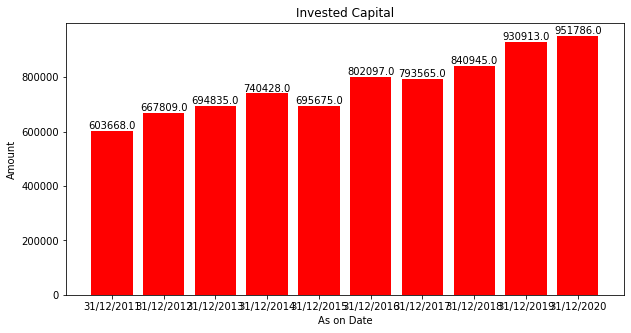

In [16]:
img = plt.figure(figsize = (10,5))
plt.bar(chart.x, chart.ic_value_y, fc = 'red')

for i in range (len(chart.x)):
    plt.text(i, chart.ic_value_y[i], chart.ic_value_y[i], ha = 'center', va = 'bottom')
    
plt.xlabel('As on Date')
plt.ylabel('Amount')

plt.title("Invested Capital")

img.savefig('invested capital value.png')

plt.show()

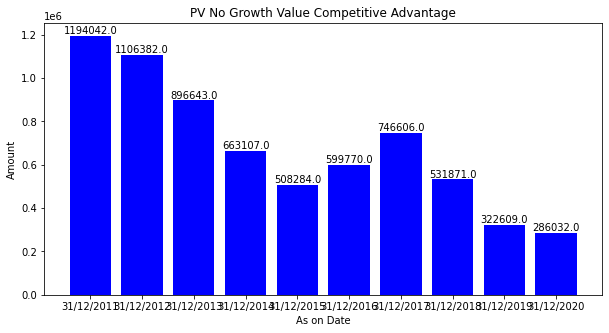

In [17]:
img = plt.figure(figsize = (10,5))
plt.bar(chart.x, chart.pv_value_y, fc = 'blue')

for i in range (len(chart.x)):
    plt.text(i, chart.pv_value_y[i], chart.pv_value_y[i], ha = 'center', va = 'bottom')

plt.xlabel('As on Date')
plt.ylabel('Amount')

plt.title("PV No Growth Value Competitive Advantage")

img.savefig('pv no growth value.png')

plt.show()

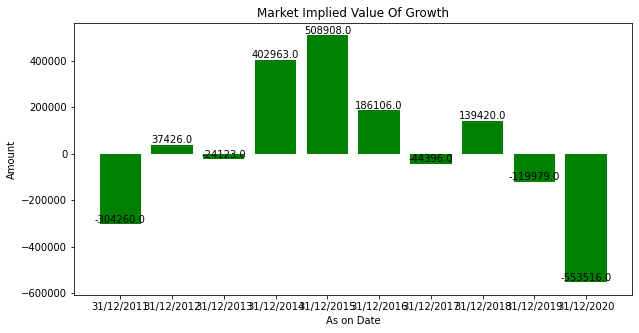

In [18]:
img = plt.figure(figsize = (10,5))
plt.bar(chart.x, chart.mv_value_y, fc = 'green')

for i in range (len(chart.x)):
    plt.text(i, chart.mv_value_y[i], chart.mv_value_y[i], ha = 'center', va = 'bottom')

plt.xlabel('As on Date')
plt.ylabel('Amount')

plt.title("Market Implied Value Of Growth")

img.savefig('mv implied growth value.png')

plt.show()

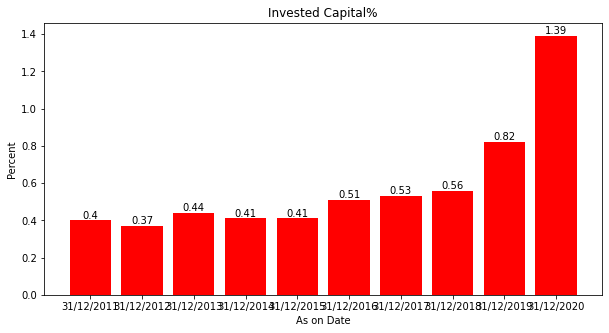

In [19]:
img = plt.figure(figsize = (10,5))
plt.bar(chart.x, chart.ic_percent_y, fc = 'red')

for i in range (len(chart.x)):
    plt.text(i, chart.ic_percent_y[i], chart.ic_percent_y[i], ha = 'center', va = 'bottom')

plt.xlabel('As on Date')
plt.ylabel('Percent')

plt.title("Invested Capital%")

img.savefig('invested capital percent.png')

plt.show()

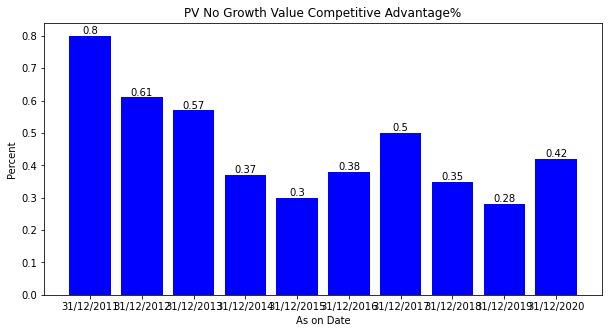

In [20]:
img = plt.figure(figsize = (10,5))
plt.bar(chart.x, chart.pv_percent_y, fc = 'blue')

for i in range (len(chart.x)):
    plt.text(i, chart.pv_percent_y[i], chart.pv_percent_y[i], ha = 'center', va = 'bottom')

plt.xlabel('As on Date')
plt.ylabel('Percent')

plt.title("PV No Growth Value Competitive Advantage%")

img.savefig('pv no growth percent.png')

plt.show()

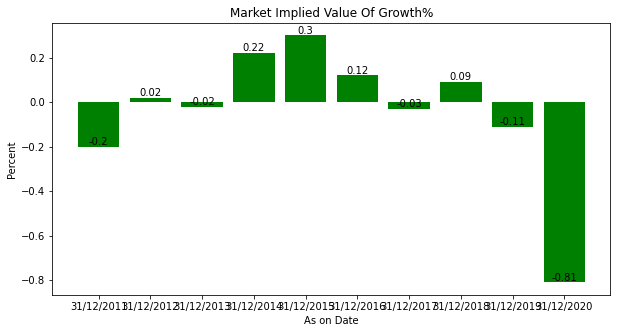

In [21]:
img = plt.figure(figsize = (10,5))
plt.bar(chart.x, chart.mv_percent_y, fc = 'green')

for i in range (len(chart.x)):
    plt.text(i, chart.mv_percent_y[i], chart.mv_percent_y[i], ha = 'center', va = 'bottom')

plt.xlabel('As on Date')
plt.ylabel('Percent')

plt.title("Market Implied Value Of Growth%")

img.savefig('mv implied growth percent.png')

plt.show()

<Figure size 720x360 with 0 Axes>

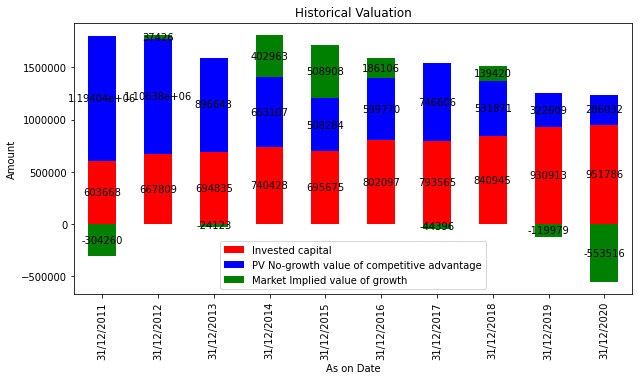

In [22]:
img = plt.figure(figsize = (10,5))

pal = ['red', 'blue', 'green']
ax = chart.stack_value.plot(kind="bar", stacked=True, figsize = (10, 5), color = pal)

for c in ax.containers:
    ax.bar_label(c, label_type='center')
    
ax.set_ylabel("Amount")
ax.set_xlabel("As on Date")

plt.title("Historical Valuation")

plt.ticklabel_format(style = 'plain', axis = 'y')

ax.figure.savefig('stackvalue.png')

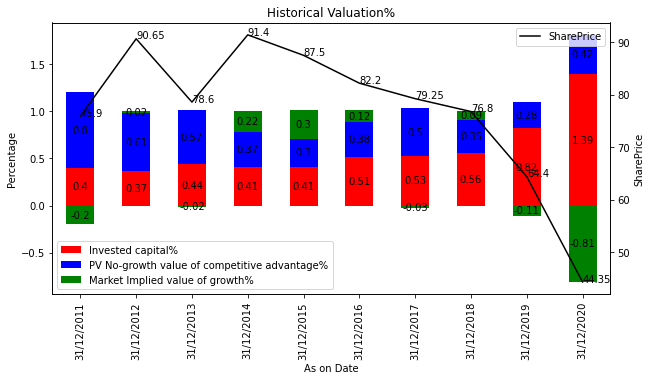

In [23]:
fig, ax = plt.subplots(figsize=(10,5))

ax2  = ax.twinx()
pal = ['red', 'blue', 'green']

chart.stack_percent[[chart.column_names[0], chart.column_names[4], chart.column_names[6], \
        chart.column_names[8]]].plot(x = chart.column_names[0], kind="bar", stacked=True, color = pal, ax = ax)
                                    

chart.stack_percent[[chart.column_names[0], chart.column_names[9]]].plot(x = chart.column_names[0], kind="line", \
                                                                 color = 'black', ax = ax2)

for c in ax.containers:
    ax.bar_label(c, label_type='center')
    

for i,j in chart.stack_percent[chart.column_names[9]].items():
    ax2.annotate(str(j), xy=(i, j))

leg = ax.legend(loc ="lower left");

ax.set_ylabel("Percentage")
ax.set_xlabel("As on Date")
ax2.set_ylabel("SharePrice")

plt.title("Historical Valuation%")

ax.figure.savefig('stackvpercent and shareprice.png')


# End of the Project